# Machine Learning 2023-2024 - UMONS

# Model selection using scikit-learn

**During the last lab, we learned how to fit regression and classification models to a dataset with scikit-learn. However, by fixing the number of features and by fixing the model's hyperparameters beforehand, we restricted ourselves to a single model. By doing so, we omitted to explore a broader range of models, one of which might better explain the relationship between our input and target variables.**

**In this lab, we'll experiment with the general methodology of model selection, meaning that we'll define a set of predefined models, and we'll retain the one that minimizes the out-of-sample error.**

**Import the necessary libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

**In this lab, we will work with the [Fish market](https://www.kaggle.com/datasets/vipullrathod/fish-market) dataset, which contains several characteristics about fish, such as their weights, lengths, and species.**

In [2]:
df = pd.read_csv('data/fish_lab.csv', index_col=0)

**1) Print the type of each column and change the type of 'Species' to `category`.**

In [3]:
df = df.astype({'Species': 'category'})
print(df.dtypes)
df.head()

Species    category
Weight      float64
Length1     float64
Length2     float64
Length3     float64
Height      float64
Width       float64
dtype: object


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


**We will start by predicting the target 'Height' from the feature 'Weight'. We split the dataset into a training and test set following a 75/25 partition using the `train_test_split` function. To avoid data leakage, we will not look at the test dataset during model selection.**

In [4]:
X, y = df[['Weight']], df['Height']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=1
)

**2) What is the number of missing values? Using the `SimpleImputer` class of scikit-learn with the argument `strategy`, replace the missing values by the sample mean, computed only on the training dataset to avoid data leakage.**

In [5]:
print(X_train.isna().sum())

imp = SimpleImputer(strategy='mean').fit(X_train)
# Note that transformers return numpy arrays, so we need to convert the result back to a DataFrame.
# - We can assign to the original DataFrame directly with `[:]`
# - Or we can create a dataframe with `pd.DataFrame(imp.transform(X_train), columns=imp.get_feature_names_out(X_train.columns))`

X_train[:] = imp.transform(X_train)
X_test[:] = imp.transform(X_test)

print(X_train.isna().sum())

Weight    6
dtype: int64
Weight    0
dtype: int64


**3) Generate a scatter plot of the two variables on the training set.**

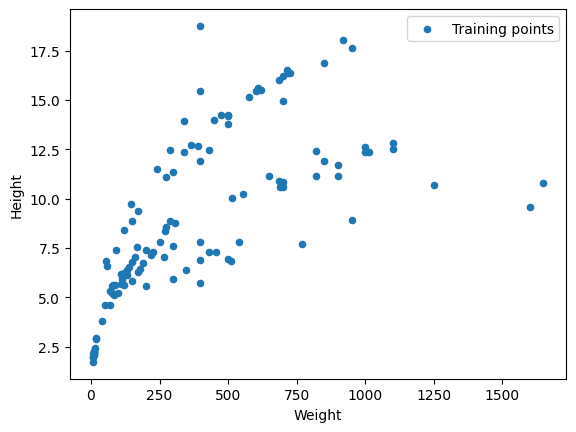

In [6]:
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='Training points', s=20)
ax.set(xlabel='Weight', ylabel='Height')
ax.legend();

**4) We can see that a linear model would not be the best option to model the relationship between these variables. Instead of fitting a linear model, let's fit a polynomial model of specified degree.**
- **scikit-learn provides various "transformers", which can transform the dataset for scaling, normalization, encoding categorical variables, filling missing values, and more. To perform polynomial regression, we will use the `PolynomialFeatures` class**.
- **scikit-learn also allows to create pipeline using `Pipeline` or `make_pipeline`, which are compositions of transformers followed by any model. Our polynomial regression model is a pipeline which first creates new features and then fits a linear regression model.**

**More information is available [here](https://scikit-learn.org/stable/data_transforms.html).**

**Create your model using the given `PolynomialRegression` function with `degree=2`. Then, plot the predictions of the model conditional to 'Weight' between 0 and 1250.**

In [7]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(SimpleImputer(strategy='mean'), PolynomialFeatures(degree), LinearRegression(**kwargs))

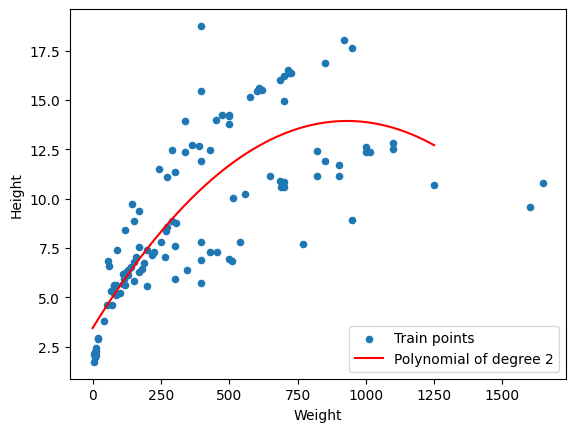

In [8]:
model = PolynomialRegression(2, fit_intercept=True)
model.fit(X_train, y_train)

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='Train points', s=20)
X_plot = pd.DataFrame({'Weight': np.linspace(0, 1250, 500)})
y_plot = model.predict(X_plot)
ax.plot(X_plot, y_plot, label='Polynomial of degree 2', color='r')
ax.set(xlabel='Weight', ylabel='Height')
ax.legend();

**5) We will now evaluate our first model with 10-fold cross-validation using the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function. In this process, the dataset is divided into 10 folds. For each fold, `cross_validate` will fit the model on the 9 other folds and test it on the remaining fold.**
- **Create a pipeline, composed of the `SimpleImputer` transformer from earlier and a `PolynomialRegression` model with degree 2.**
- **For evaluation, we will use the mean squared error (MSE). Note that scikit-learn provides [different score functions](https://scikit-learn.org/stable/modules/model_evaluation.html), which should be maximized. This is in contrast to loss functions, which should be minimized. Thus, we will use the score `neg_mean_squared_error` (the negation of the MSE), and we should not forget to take the negation when reporting it.**
- **Call `cross_validate` with 10 folds and specify the score function using the `scoring` argument. Since `X_train` and `y_train` have been modified previously with `SimpleImputer`, there will be data leakage between folds. Instead, use the given `X_train_raw` and `y_train_raw` as argument.**
- **Report the test MSE on each fold based on the dictionary of metrics returned by [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). Then, report the mean test MSE across all fold.**

In [9]:
# We recreate the train and test sets because we modified the train set earlier.
X, y = df[['Weight']], df['Height']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=1
)

In [10]:
model = make_pipeline(SimpleImputer(strategy='mean'), PolynomialRegression(2, fit_intercept=True))
cv_results = cross_validate(model, X_train_raw, y_train_raw, cv=10, scoring=['neg_mean_squared_error'])
test_mse = -cv_results['test_neg_mean_squared_error']
print('Test MSE on each fold:', ', '.join(f'{x:.2f}' for x in test_mse))
print(f'Mean test MSE across all folds: {test_mse.mean():.2f}')

Test MSE on each fold: 5.56, 3.16, 4.90, 2.54, 13.47, 3.14, 5.11, 6.29, 6.19, 13.99
Mean test MSE across all folds: 6.44


**Let's now see how predictions vary with the model complexity. We go back to using the train and test sets defined earlier. For polynomial degrees between 1 and 5, we repeatedly fit the polynomial regression model (without cross-validation) and plot the predictions of 'Height' in function of the feature 'Weight'. What do you observe?**

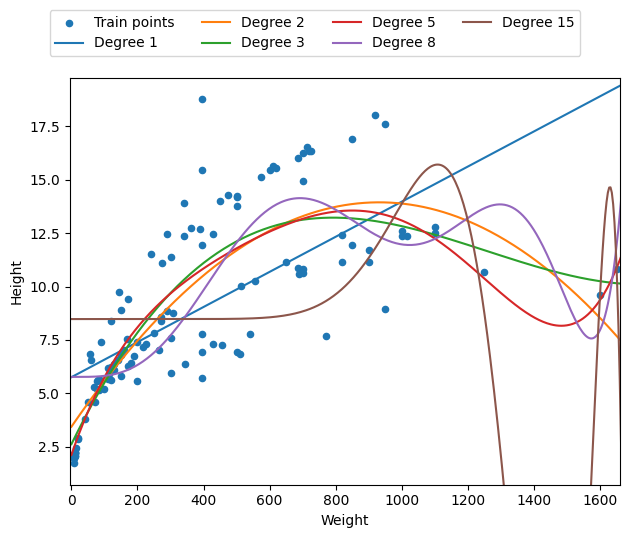

In [11]:
models = []
degrees = [1, 2, 3, 5, 8, 15]
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    model.fit(X_train, y_train)
    models.append(model)

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='Train points', s=20)
X_plot = pd.DataFrame({'Weight': np.linspace(0, 2000, 500)})
for model in models:
    degree = model.get_params()['polynomialfeatures__degree']
    y_plot = model.predict(X_plot)
    ax.plot(X_plot, y_plot, label=f'Degree {degree}')
ax.set_xlim([X_train['Weight'].min() - 10, X_train['Weight'].max() + 10])
ax.set_ylim([y_train.min() - 1, y_train.max() + 1])
ax.set(xlabel='Weight', ylabel='Height')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncol=4)
fig.tight_layout()

We observe that the polynomial of degree 1 underfits while the polynomial of degree 8 overfits.

**6) Collect and plot the evolution of the train and test MSE of the models from the previous question in function of the polynomial degree. Which model would you select?**

Degree 1: test MSE = 8.34
Degree 2: test MSE = 5.53
Degree 3: test MSE = 6.82
Degree 5: test MSE = 6.74
Degree 8: test MSE = 6.63
Degree 15: test MSE = 18.96


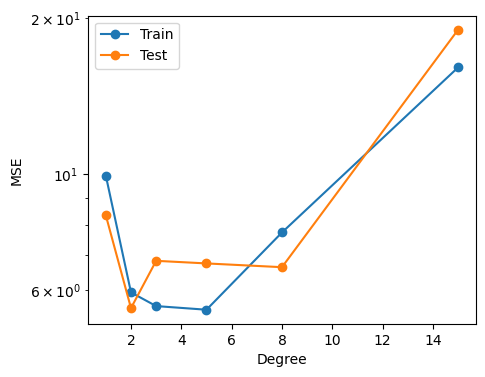

In [12]:
mse_train_list, mse_test_list = [], []
for model in models:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    mse_train_list.append(train_mse)
    mse_test_list.append(test_mse)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(degrees, mse_train_list, '-o', label='Train')
ax.plot(degrees, mse_test_list, '-o', label='Test')
ax.set(xlabel='Degree', ylabel='MSE')
ax.set_yscale('log')
ax.legend()

for degree, mse in zip(degrees, mse_test_list):
    print(f'Degree {degree}: test MSE = {mse:.2f}')

The polynomial of degree 2 achieves the lowest test MSE and should be selected.

**In the rest of this lab, we will predict the target 'Height' based on all available features. We split again the dataset into a training and test set following a 75/25 partition using the `train_test_split` function.**

In [13]:
X, y = df.drop(columns='Height'), df[['Height']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=1
)

**7) We will now create a more complex pipeline to preprocess the data:**
- **For continuous variables, we replace the missing values by the sample mean.**
- **For missing categorical variables, replace missing value by the sample mode (the most frequent value).**
- **After replacing missing categorical variables, we replace them by dummy variables using the `OneHotEncoder`.**
- **To execute different transformers on different columns, we can use `ColumnTransformer`**

**For this, combine the transformers `SimpleImputer`, `OneHotEncoder` and `ColumnTransformer` into a single pipeline.**

In [14]:
# We can select continuous and categorical columns using this method
cont_columns = X_train.select_dtypes(include=['float64']).columns
cat_columns = X_train.select_dtypes(include=['category']).columns
print('Continuous columns:', cont_columns)
print('Categorical columns:', cat_columns)

Continuous columns: Index(['Weight', 'Length1', 'Length2', 'Length3', 'Width'], dtype='object')
Categorical columns: Index(['Species'], dtype='object')


In [15]:
# Transformers for imputation
cont_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_pipeline = make_pipeline(cat_imputer, OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

# ColumnTransformer to apply transformations to the correct features
preprocessor = ColumnTransformer(transformers=[
    ('cont', cont_imputer, cont_columns),
    ('cat', cat_pipeline, cat_columns)
])

**8) Usually, models have more than one hyperparameter that can be tuned in order to find the model that best captures the relationship between our input and target variables. For instance, in the case of a simple linear regression using a polynomial transformation on the input variables, we can choose the hyperparameter space to be the polymial's degree, and whether or not to fit the intercept. Inspecting each combination of hyperparameters and selecting the combination that results in the best model is called grid search.**

**scikit-learn provides the class [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which evaluates each combination of hyperparameters using cross-validation. After fitting, we can get relevant attributes:**
- **`cv_results_` is a summary of the results and can be converted to a pandas dataframe`.**
- **`best_index_` is the index of `cv_results_` for the best model.**
- **`best_params_` is the parameters of the best model.**

**Perform a grid search on the hyperparameter space of a polynomial regression model (with all features). Search for degrees varying between 1 and 5, and whether or not the intercept should be fit. Report the best hyperparameters and the corresponding MSE.**

In [16]:
param_grid = {
    'polynomialfeatures__degree': np.arange(1, 6),
    'linearregression__fit_intercept': [True, False],
}

pipeline = make_pipeline(preprocessor, PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearregression__fit_intercept,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.050024,0.020336,0.008154,0.004123,True,1,"{'linearregression__fit_intercept': True, 'pol...",-3.040212e+00,-3.549168e+00,-5.719280e-01,-2.701322e-01,-3.834504e+00,-5.566881e-01,-4.275382e-01,-1.848803e-01,-4.463557e-01,-1.381863e+00,-1.426327e+00,1.386887e+00,2
1,0.013029,0.001181,0.006166,0.000647,True,2,"{'linearregression__fit_intercept': True, 'pol...",-1.071874e+00,-4.480988e+00,-7.125998e-01,-1.565505e+08,-9.385169e-01,-1.573036e+02,-2.110432e+00,-1.087832e+17,-4.869248e+00,-2.105773e+00,-1.087832e+16,3.263496e+16,10
2,0.016968,0.003904,0.007150,0.001957,True,3,"{'linearregression__fit_intercept': True, 'pol...",-7.015012e+06,-3.010516e+06,-8.775543e+07,-5.033039e+03,-1.293508e+06,-2.006391e+05,-4.607430e+05,-2.679537e+07,-1.124401e+05,-5.724080e+05,-1.272211e+07,2.619356e+07,4
3,0.025348,0.006723,0.007460,0.000785,True,4,"{'linearregression__fit_intercept': True, 'pol...",-1.335568e+07,-9.376565e+06,-2.828609e+08,-6.905332e+03,-1.398494e+05,-2.737342e+05,-5.240500e+06,-5.875512e+09,-6.141687e+05,-4.311865e+07,-6.230499e+08,1.752766e+09,6
4,0.057937,0.016546,0.007366,0.000627,True,5,"{'linearregression__fit_intercept': True, 'pol...",-1.414319e+09,-7.212842e+07,-3.854544e+09,-7.018104e+05,-1.139689e+06,-6.631415e+05,-3.407740e+05,-1.983285e+12,-4.364008e+09,-1.047600e+10,-2.003469e+11,5.943211e+11,7
5,0.012479,0.000507,0.006320,0.000252,False,1,"{'linearregression__fit_intercept': False, 'po...",-3.040212e+00,-3.549168e+00,-5.719280e-01,-2.701322e-01,-3.834504e+00,-5.566881e-01,-4.275382e-01,-1.848803e-01,-4.463557e-01,-1.381863e+00,-1.426327e+00,1.386887e+00,1
6,0.015765,0.005571,0.011681,0.006936,False,2,"{'linearregression__fit_intercept': False, 'po...",-8.089012e-01,-3.038344e+00,-7.759996e-01,-4.315999e+08,-9.806742e-01,-1.520058e+02,-1.943106e+00,-8.607039e+12,-5.358971e+00,-2.035239e+00,-8.607471e+11,2.582097e+12,9
7,0.015512,0.000737,0.006897,0.000349,False,3,"{'linearregression__fit_intercept': False, 'po...",-8.687289e+06,-3.100729e+06,-3.747865e+07,-6.020728e+03,-1.315876e+06,-1.638965e+05,-3.275081e+05,-5.300513e+06,-1.268108e+05,-1.636313e+06,-5.814360e+06,1.088264e+07,3
8,0.020240,0.002037,0.007436,0.000884,False,4,"{'linearregression__fit_intercept': False, 'po...",-1.495926e+07,-9.485594e+06,-3.064778e+08,-8.179504e+03,-1.018612e+05,-2.708172e+05,-4.716867e+06,-3.090032e+09,-2.375143e+05,-2.267620e+07,-3.448966e+08,9.194314e+08,5
9,0.045312,0.009777,0.007178,0.001825,False,5,"{'linearregression__fit_intercept': False, 'po...",-2.479899e+08,-3.169558e+08,-4.738312e+09,-1.123019e+06,-1.240268e+06,-2.530281e+06,-2.129271e+05,-8.243155e+12,-1.126892e+09,-4.996894e+08,-8.250090e+11,2.472716e+12,8


In [17]:
# We select the best index and reconvert to a dataframe for visualisation
best_results = cv_results.loc[grid.best_index_].to_frame().T
best_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearregression__fit_intercept,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,0.012479,0.000507,0.00632,0.000252,False,1,"{'linearregression__fit_intercept': False, 'po...",-3.040212,-3.549168,-0.571928,-0.270132,-3.834504,-0.556688,-0.427538,-0.18488,-0.446356,-1.381863,-1.426327,1.386887,1


In [18]:
best_test_mse = -best_results['mean_test_score'].item()
print(f'Best hyperparameters subset: {grid.best_params_}')
print(f'Test MSE using best hyperparameters subset: {best_test_mse:.2f}')

Best hyperparameters subset: {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 1}
Test MSE using best hyperparameters subset: 1.43


Perhaps surprisingly, the best score was obtained with a polynomial of degree 1. Although introducing more features offers greater flexibility to the model, it also raises the chance of the model fitting to noise within the features - an indication of overfitting.

**9) Finally, fit a model using the best hyperparameters on the full training dataset. You can use the function `set_params` of scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) classes. Collect the predictions on the test set in a variable `y_pred` and report the test MSE.**

In [19]:
model = pipeline.set_params(**grid.best_params_)
y_pred = model.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE using the full training dataset: {mse:.2f}')

Test MSE using the full training dataset: 1.06


We observe that the MSE decreases when the full training dataset is available.

**For visualization, we plot the predicted values of 'Height' as a function 'Weight'. Note that, due to the presence of other variables, the model is able to represent non-linear relationships between the two variables.**

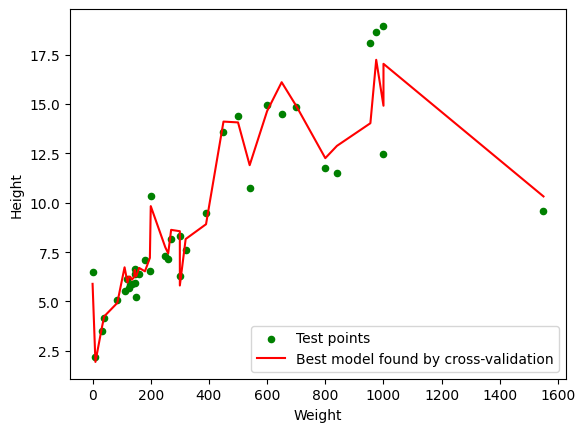

In [20]:
# We sort according to the x-axis for visualization purposes
x_label = 'Weight'
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
X_test = X_test.sort_values(x_label)
y_test = y_test.loc[X_test.index]
y_pred = y_pred[X_test.index]

fig, ax = plt.subplots()
ax.scatter(X_test[x_label], y_test, color='green', label='Test points', s=20)
ax.plot(X_test[x_label], y_pred, label='Best model found by cross-validation', color='r')
ax.set(xlabel=x_label, ylabel='Height')
ax.legend();

**Optional experiments: try to improve the performance of the model by manually transforming the features. For example add the squared 'Weight' as a feature.**